Get the complete data_set, together with the train and test data_set

In [1]:
from tf_chpvk_pv.dataset import *
import pandas as pd

df = create_dataset(use_turnley_radii=True)
train_df, test_df = train_test_split_()

2026-02-12 09:45:22.500 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


2026-02-12 09:45:31.939 | INFO     | tf_chpvk_pv.dataset:create_dataset:41 - Processing dataset...
2026-02-12 09:45:33.370 | SUCCESS  | tf_chpvk_pv.dataset:create_dataset:213 - Processing dataset complete.
2026-02-12 09:45:35.405 | INFO     | tf_chpvk_pv.dataset:train_test_split_:227 - Creating train and test dataset...
2026-02-12 09:45:35.453 | SUCCESS  | tf_chpvk_pv.dataset:train_test_split_:261 - Creating train and test dataset complete.


In [2]:
#count the number of material in each class in the training/test sets
dict_ch = {133:'F',
        181:'Cl',
        198:'Se',
        196.0:'Br',
        184.0:'S',
        220.00000000000003:'I'
        }

train_df['X'] = train_df.replace({'rX':dict_ch})['rX']
test_df['X'] = test_df.replace({'rX':dict_ch})['rX']

train_vc = pd.DataFrame(train_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())
test_vc = pd.DataFrame(test_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())

print('In the training set, %s compositions are unstable and %s are stable.' % (train_df['exp_label'].value_counts().values[0], train_df['exp_label'].value_counts().values[1]))
print('The distribution in the training set by anions is the following')
display(train_vc)

print('In the test set, %s compositions are unstable and %s are stable.' % (test_df['exp_label'].value_counts().values[0], test_df['exp_label'].value_counts().values[1]))
print('The distribution in the test set by anions is the following')
display(test_vc)

In the training set, 141 compositions are unstable and 85 are stable.
The distribution in the training set by anions is the following


count
X  exp_label       
Br 0.0           17
   1.0            4
Cl 0.0           43
   1.0           14
F  1.0           40
   0.0           13
I  0.0           29
   1.0            5
S  0.0           26
   1.0           21
Se 0.0           13
   1.0            1

In the test set, 34 compositions are unstable and 23 are stable.
The distribution in the test set by anions is the following


count
X  exp_label       
Br 0.0            5
   1.0            1
Cl 0.0           10
   1.0            4
F  1.0           11
   0.0            2
I  0.0            7
   1.0            2
S  0.0            7
   1.0            5
Se 0.0            3

Train the SISSO model to obtain the features

In [3]:
from tf_chpvk_pv.features import run_SISSO_model

Inputs = run_SISSO_model()

2026-02-12 09:45:35.554 | SUCCESS  | tf_chpvk_pv.features:run_SISSO_model:68 - SISSO Features were already generated.


Train tree models with the SISSO features, to decide the best t_sisso

2026-02-12 09:45:36.798 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features_Ch:124 - Training tree model with SISSO features...
Identified expression for t_sisso: (|((rA_rX_ratio + rB_rX_ratio) + (|rB_rX_ratio - log_rA_rB_ratio|)) - (rA_rX_ratio**3)|)
Classification tree f1 (for t_sisso) on the train set: 0.845133.
Classification tree f1 (for t_sisso) on the train set (5 fold CV): 0.765626.
Classification tree f1 (for t_sisso) on the test set: 0.894737.
t_sisso < 0.845501 indicates stable perovskites.
Classification tree f1 (for t) on the train set: 0.747788.
Classification tree f1 (for t) on the train set (5 fold CV): 0.654770.
Classification tree f1 (for t) on the test set: 0.596491.
0.851217 < t < 0.953118 indicates stable perovskites.
Classification tree f1 (for tau) on the train set: 0.738938.
Classification tree f1 (for tau) on the train set (5 fold CV): 0.741283.
Classification tree f1 (for tau) on the test set: 0.684211.
tau < 4.180000 indicates stable perovskites.


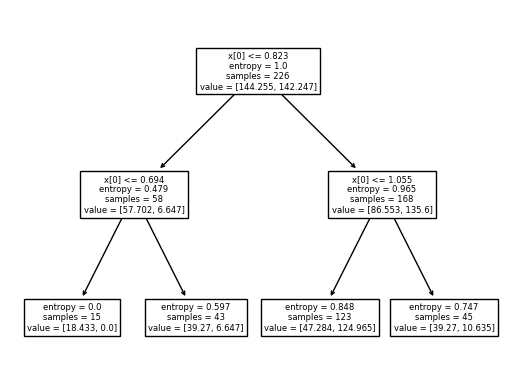

In [4]:
from tf_chpvk_pv.modeling.train import *
from tf_chpvk_pv.config import INTERIM_DATA_DIR
import pickle

t_sisso_expression = train_tree_sis_features_Ch()
train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression)

tfs = ['t_sisso', 't', 'tau', 't_jess']
tf_tresh = [1, 2, 1, 2]

df_acc =pd.DataFrame()
clfs = {}

for tf, tresh in zip(tfs, tf_tresh):
    df_acc, clf_t = test_tolerance_factor_Ch(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
    clfs[tf] = clf_t

path_dict = INTERIM_DATA_DIR / "tolerance_factors.pkl"
path_clfs = INTERIM_DATA_DIR / "tolerance_factor_classifiers.pkl"

with open(path_dict, 'wb') as file:
    pickle.dump(tolerance_factor_dict, file)

with open(path_clfs, 'wb') as file:
    pickle.dump(clfs, file)

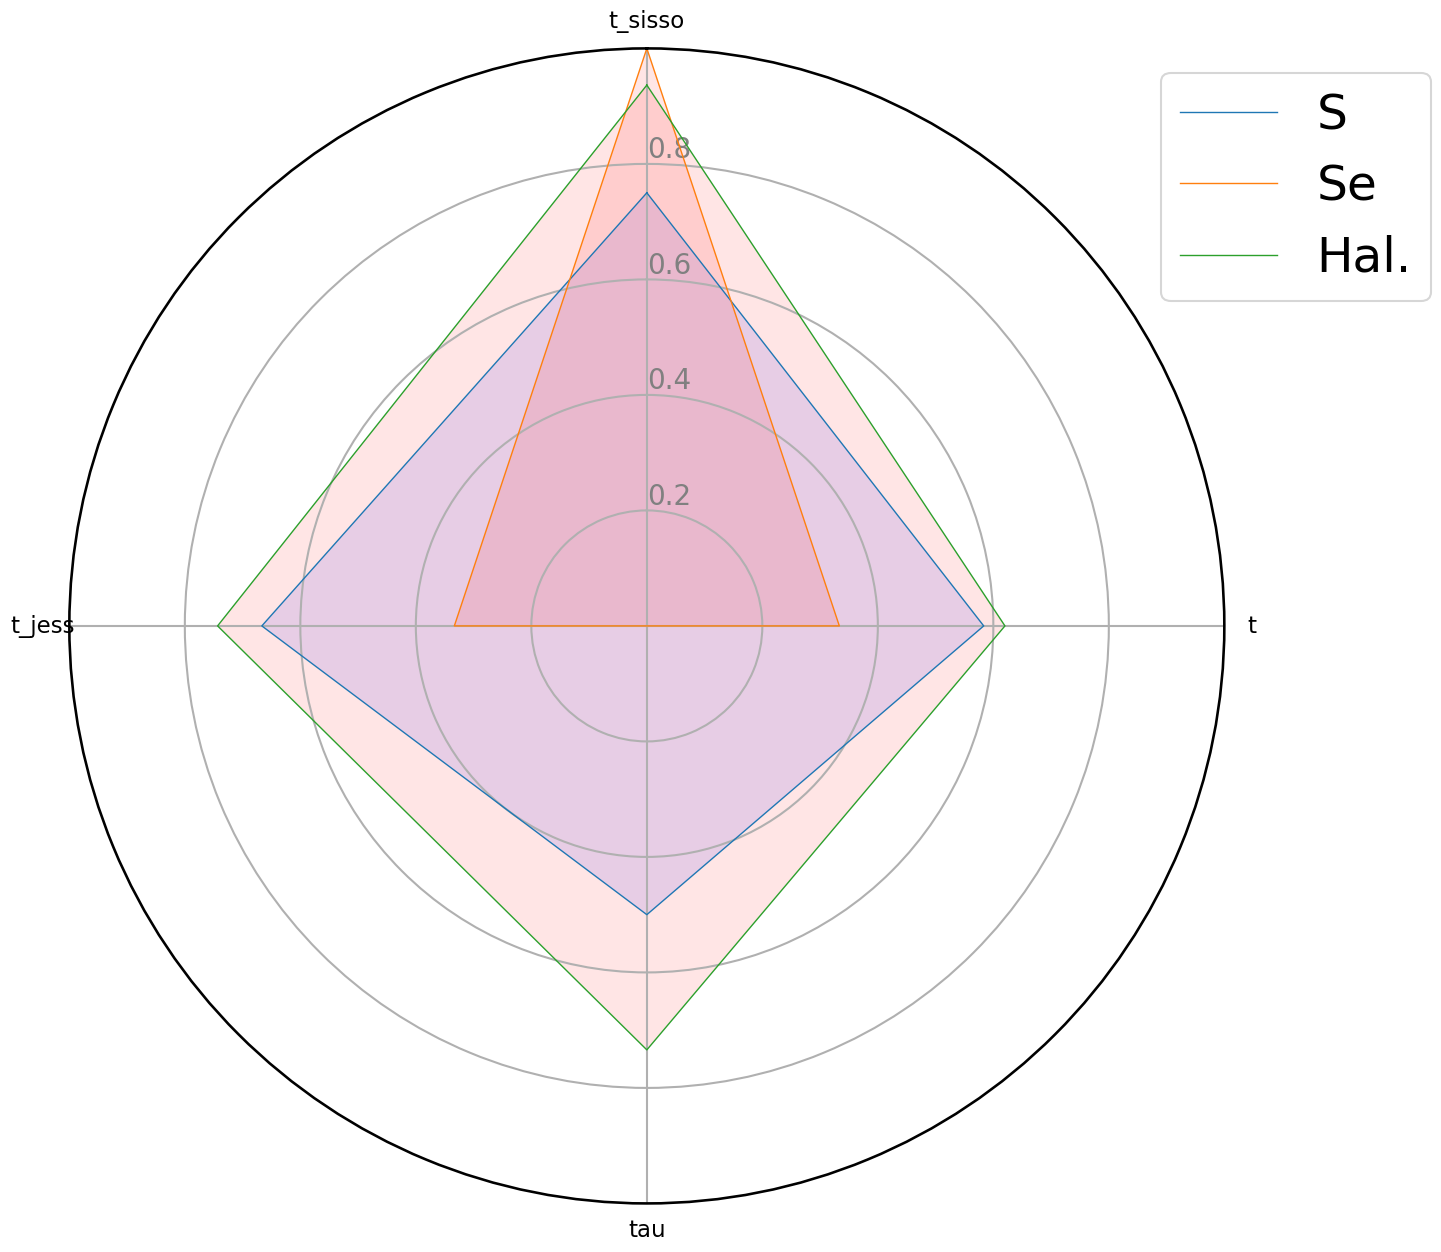

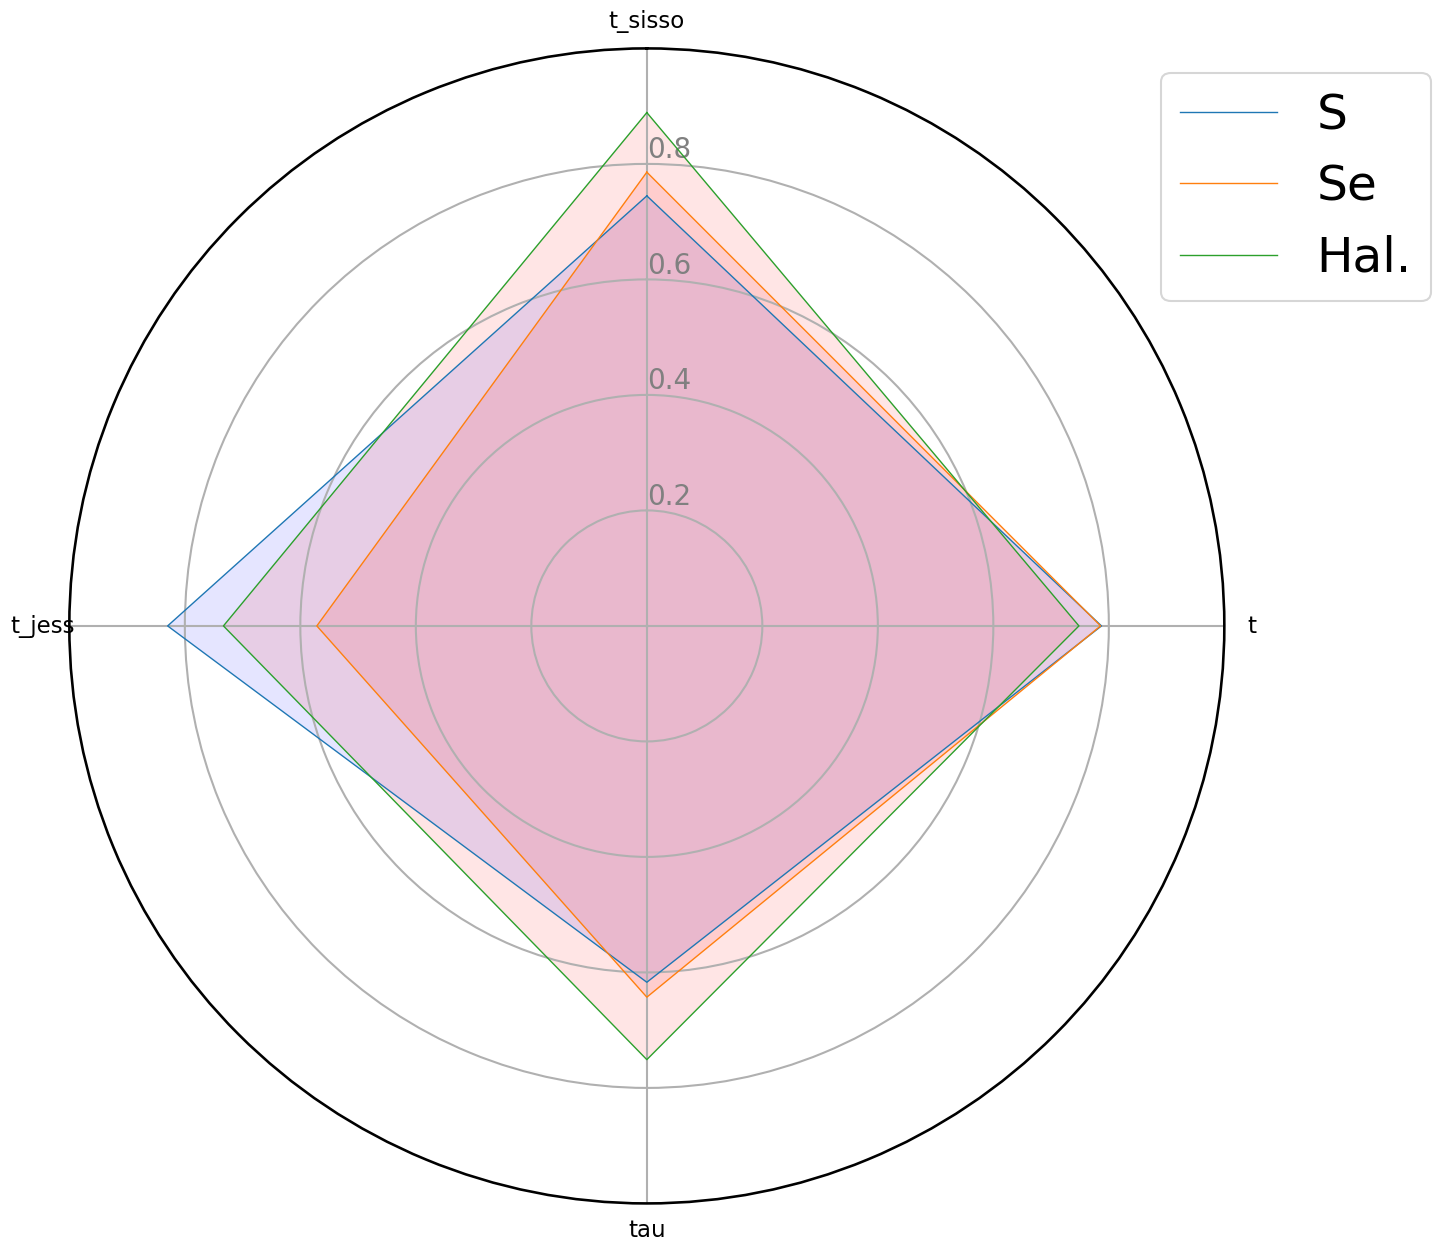

In [5]:
from tf_chpvk_pv.plots import spider_plot
import seaborn as sns

sns.set_context('talk')

test_idx = [x for x in df_acc.index if 'test' in x]
train_idx = [x for x in df_acc.index if 'train' in x]
test_acc = df_acc.loc[test_idx]
train_acc = df_acc.loc[train_idx]

test_acc.index = ['test_data', 'S', 'I', 'Cl','Br', 'F', 'Se']
train_acc.index = ['test_data', 'S', 'I', 'Cl','Br', 'F', 'Se']

#find mean for halides
test_hal = test_acc.loc[['I', 'Cl', 'Br', 'F']].mean(axis=0)
train_hal = train_acc.loc[['I', 'Cl', 'Br', 'F']].mean(axis=0)

test_acc['group'] = ['test_data', 'S', 'I', 'Cl','Br', 'F', 'Se']
train_acc['group'] = ['test_data', 'S', 'I', 'Cl','Br', 'F', 'Se']

test_acc.loc['hal'] = test_hal
test_acc.loc['hal', 'group'] = 'Hal.'

train_acc.loc['hal'] = train_hal
train_acc.loc['hal', 'group'] = 'Hal.'

spider_plot(test_acc, 'test data')
spider_plot(train_acc, 'train data')

2026-02-12 09:46:38.568 | INFO     | tf_chpvk_pv.modeling.train:train_platt_scaling:49 - Training Platt scaling model...
2026-02-12 09:46:38.782 | SUCCESS  | tf_chpvk_pv.modeling.train:train_platt_scaling:65 - Platt scaling model training complete.
2026-02-12 09:46:38.807 | INFO     | tf_chpvk_pv.plots:platt_scaling_plot:53 - Generating Platt Scaling plot from data...
2026-02-12 09:46:40.980 | SUCCESS  | tf_chpvk_pv.plots:platt_scaling_plot:70 - Plot generation complete.


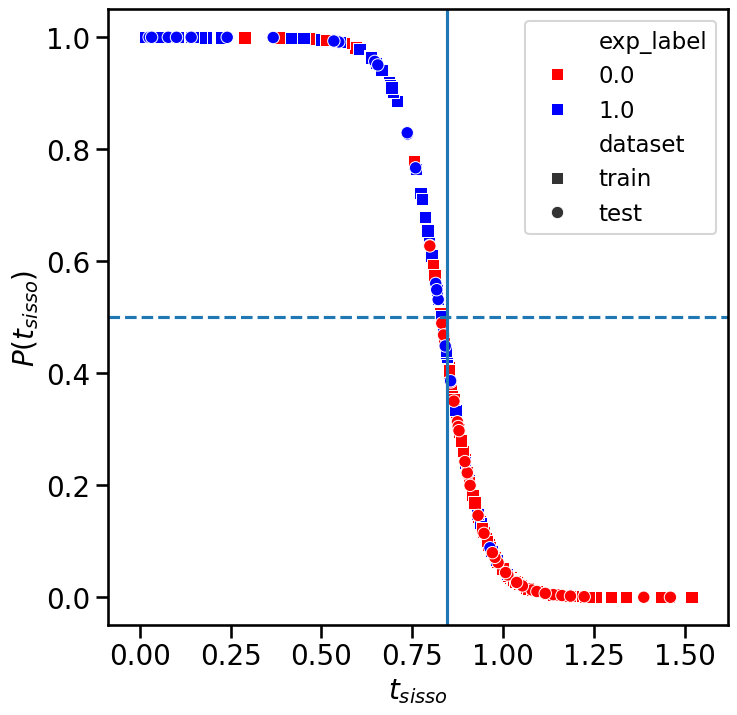

In [6]:
from tf_chpvk_pv.plots import platt_scaling_plot
from tf_chpvk_pv.modeling.train import train_platt_scaling
import seaborn as sns

sns.set_context('talk')

train_df, test_df, cl2_tsisso = train_platt_scaling(train_df, test_df, clfs['t_sisso'])
platt_scaling_plot('t_sisso')

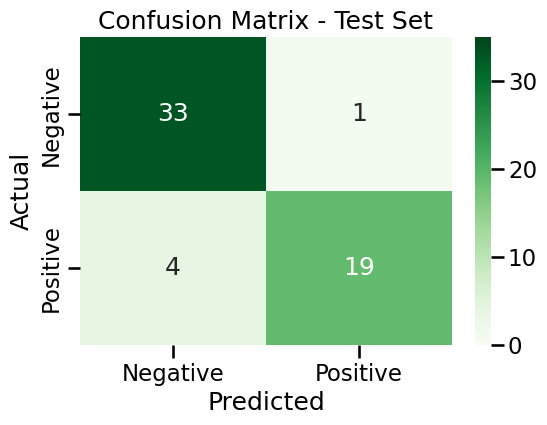

In [7]:
#Confusion matrix - test set
from tf_chpvk_pv.plots import confusion_matrix_plot

confusion_matrix_plot(test_df)

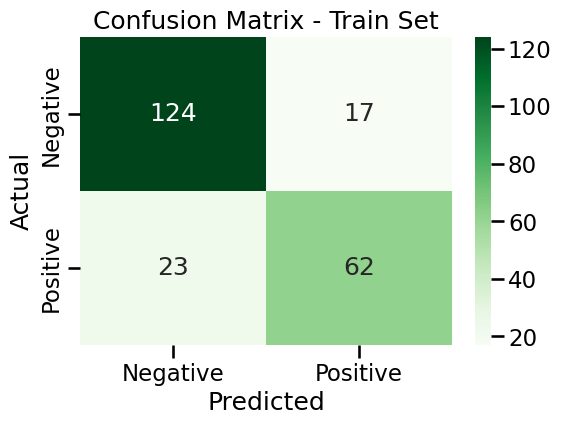

In [8]:
#Confusion matrix - train set
from tf_chpvk_pv.plots import confusion_matrix_plot

confusion_matrix_plot(train_df, test=False)

confusion matrix for t_jess on test set:
[[21 13]
 [ 4 19]]


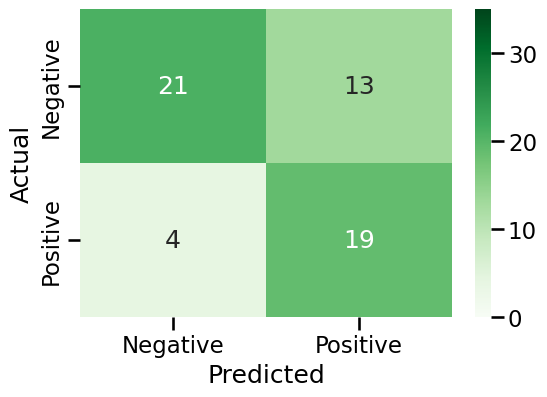

In [9]:
from sklearn.metrics import confusion_matrix
from tf_chpvk_pv.config import FIGURES_DIR
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

y_true = test_df['exp_label'].values

y_pred = np.zeros_like(y_true)
#0.823404 < t_jess < 1.055433
y_pred[(test_df['t_jess'] < 1.055433) & (test_df['t_jess'] > 0.823404)] = 1

cm = confusion_matrix(y_true, y_pred)
print('confusion matrix for t_jess on test set:')
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'], vmax=35, vmin=0)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(FIGURES_DIR / f'confusion_matrix_t_jess.png', dpi=600, bbox_inches='tight')
plt.show()

confusion matrix for t on test set:
[[20 14]
 [ 9 14]]


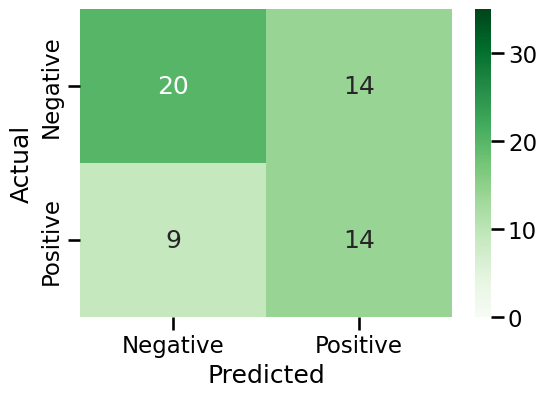

In [10]:
from sklearn.metrics import confusion_matrix
from tf_chpvk_pv.config import FIGURES_DIR
import matplotlib.pyplot as plt
import seaborn as sns

y_true = test_df['exp_label'].values

y_pred = np.zeros_like(y_true)
#0.851217 < t < 0.953118
y_pred[(test_df['t'] < 0.953118) & (test_df['t'] > 0.851217)] = 1

cm = confusion_matrix(y_true, y_pred)
print('confusion matrix for t on test set:')
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'], vmax=35, vmin=0)

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.savefig(FIGURES_DIR / f'confusion_matrix_t.png', dpi=600, bbox_inches='tight')
plt.show()

confusion matrix for tau on test set:
[[21 13]
 [ 4 19]]


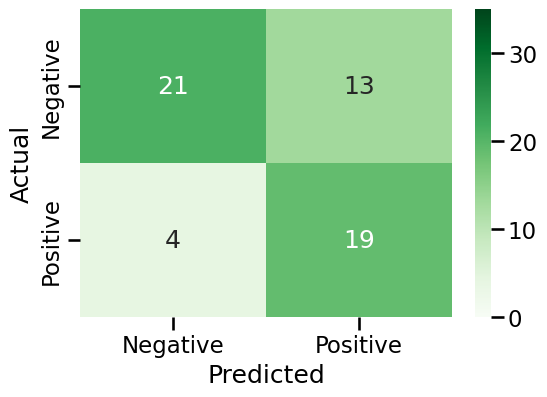

In [11]:
from sklearn.metrics import confusion_matrix
from tf_chpvk_pv.config import FIGURES_DIR
import matplotlib.pyplot as plt
import seaborn as sns

y_true = test_df['exp_label'].values

y_pred = np.zeros_like(y_true)

y_pred[(test_df['tau'] < 4.180)] = 1
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_true, y_pred)
print('confusion matrix for tau on test set:')
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'], vmax=35, vmin=0)

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.savefig(FIGURES_DIR / f'confusion_matrix_tau.png', dpi=600, bbox_inches='tight')
plt.show()

Now let's create new possible compositions

In [9]:
from tf_chpvk_pv.dataset import generate_compositions
from tf_chpvk_pv.modeling.predict import check_stable_compositions

element_selection_A = ["Ba", "Eu", "Pb", "Sr", "Ca", "Sn", "Cd", "Cu", "Mg",
                      "Zn", "Ge", "La", "Pr", "Ce", "Nd", "Yb", "Gd", "Sm", "Y",
                      "Dy", "Ho", "Er", "Tm", "Lu", "Sc", "Tl", "Bi"]

elements_selection_B = ["Si", "Ge", "V", "Rh", "Ti", "Ru", "Mo", "Ta", "Nb", "Hf",
                        "Zr", "Tb", "Pt", "Ce", "U", "Pd", "Ni", "Co", "Ga", "Al",
                        "Fe", "Cr", "In", "Mn", "Sc", "Lu", "Tm", "Er", "Ho", "Y",
                        "Yb"]

elements_selection = element_selection_A + elements_selection_B

possible_oxidation_states = [2.0, 3.0, 4.0] #3, 4] #for A and B elements

df_generated_comp = generate_compositions(elements_selection, use_turnley_radii=True).dropna()

2025-12-19 21:12:43.922 | INFO     | tf_chpvk_pv.dataset:generate_compositions:298 - Generating valid compositions...
Invalid composition: CuBiS3
Invalid composition: CuBiSe3
Invalid composition: VCuS3
Invalid composition: VCuSe3
Invalid composition: CuRuS3
Invalid composition: CuRuSe3
Invalid composition: CuMoS3
Invalid composition: CuMoSe3
Invalid composition: TaCuS3
Invalid composition: TaCuSe3
Invalid composition: NbCuS3
Invalid composition: NbCuSe3
Invalid composition: CuPtS3
Invalid composition: CuPtSe3
Invalid composition: CrCuS3
Invalid composition: CrCuSe3
Invalid composition: TlVS3
Invalid composition: TlVSe3
Invalid composition: TlRuS3
Invalid composition: TlRuSe3
Invalid composition: TlMoS3
Invalid composition: TlMoSe3
Invalid composition: TaTlS3
Invalid composition: TaTlSe3
Invalid composition: NbTlS3
Invalid composition: NbTlSe3
Invalid composition: TlPtS3
Invalid composition: TlPtSe3
Invalid composition: UTlS3
Invalid composition: UTlSe3
Invalid composition: TlCrS3
Inval

According to t_sisso, 181 (13.00287356321839%) compositions are predicted to be stable as perovskites:
['BaSnS3', 'BaPrS3', 'BaCeS3', 'BaHfS3', 'BaZrS3', 'BaUS3', 'BaUSe3', 'EuSnS3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuYbS3', 'EuYbSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuTlS3', 'EuHfS3', 'EuZrS3', 'EuTbS3', 'EuTbSe3', 'EuUS3', 'EuUSe3', 'EuInS3', 'EuInSe3', 'PbSnS3', 'PbPrS3', 'PbCeS3', 'PbHfS3', 'PbZrS3', 'SrSnS3', 'SrPrS3', 'SrCeS3', 'SrHfS3', 'SrZrS3', 'SrUS3', 'SrUSe3', 'CaSnS3', 'CaCeS3', 'CaUSe3', 'SnGeS3', 'SnGeSe3', 'SnVS3', 'SnVSe3', 'SnRhS3', 'SnRhSe3', 'SnAlSe3', 'CdCeS3', 'CdUSe3', 'CuPrS3', 'CuPrSe3', 'CuCeSe3', 'CuScSe3', 'CuTlSe3', 'CuHfS3', 'CuHfSe3', 'CuZrS3', 'CuZrSe3', 'MgPrS3', 'MgCeS3', 'MgHfS3', 'MgZrS3', 'ZnTaS3', 'ZnTaSe3', 'ZnNbS3', 'ZnNbSe3', 'ZnTbS3', 'ZnTbSe3', 'LaScS3', 'LaTlS3', 'LaHfS3', 'LaZrS3', 'LaTbS3', 'LaTbSe3', 'LaInS3', 'LaInSe3', 'PrLuSe3', 'PrScS3', 'PrTlS3', 'PrTbS3', 'PrTbSe3

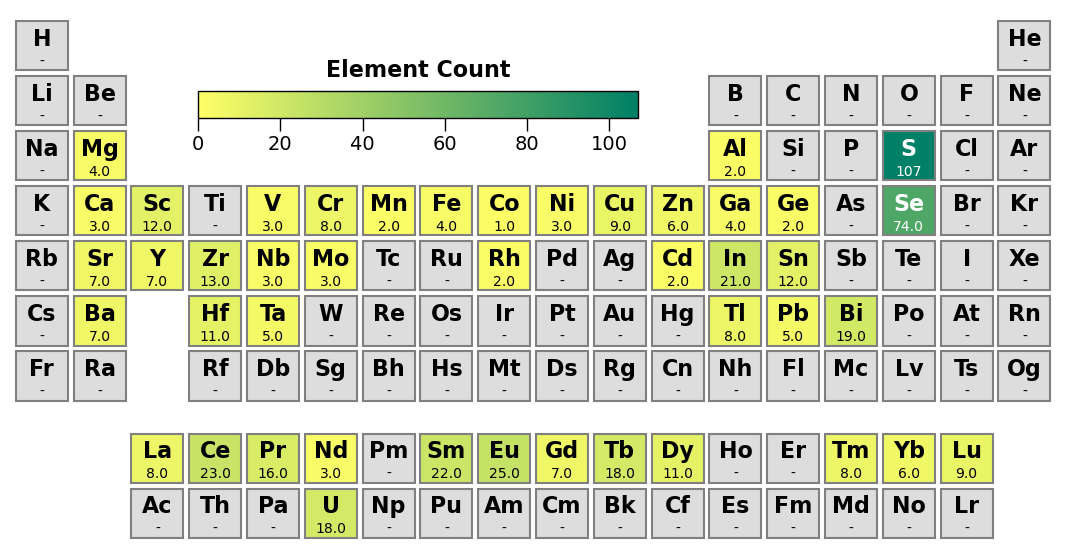

In [11]:
from tf_chpvk_pv.plots import graph_periodic_table
import seaborn as sns

sns.set_context('talk')

stable_candidates_t_sisso, df_out = check_stable_compositions('t_sisso')

graph_periodic_table(stable_candidates_t_sisso)

According to tau, 781 (56.106321839080465%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPbSe3', 'BaSnS3', 'BaSnSe3', 'BaPrS3', 'BaPrSe3', 'BaCeS3', 'BaCeSe3', 'BaTiS3', 'BaTaS3', 'BaTaSe3', 'BaNbS3', 'BaNbSe3', 'BaHfS3', 'BaHfSe3', 'BaZrS3', 'BaZrSe3', 'BaTbS3', 'BaTbSe3', 'BaUS3', 'EuPbS3', 'EuSnS3', 'EuCuS3', 'EuCuSe3', 'EuPrS3', 'EuPrSe3', 'EuCeS3', 'EuCeSe3', 'EuYbS3', 'EuYbSe3', 'EuGdS3', 'EuGdSe3', 'EuYS3', 'EuYSe3', 'EuDyS3', 'EuDySe3', 'EuHoS3', 'EuHoSe3', 'EuErS3', 'EuErSe3', 'EuTmS3', 'EuTmSe3', 'EuLuS3', 'EuLuSe3', 'EuScS3', 'EuScSe3', 'EuTlS3', 'EuTlSe3', 'EuRhS3', 'EuRhSe3', 'EuTiS3', 'EuMoS3', 'EuMoSe3', 'EuTaS3', 'EuNbS3', 'EuHfS3', 'EuZrS3', 'EuTbS3', 'EuTbSe3', 'EuNiS3', 'EuNiSe3', 'EuCoS3', 'EuCoSe3', 'EuGaS3', 'EuGaSe3', 'EuAlS3', 'EuAlSe3', 'EuFeS3', 'EuFeSe3', 'EuCrS3', 'EuCrSe3', 'EuInS3', 'EuInSe3', 'EuMnS3', 'EuMnSe3', 'SrSnS3', 'SrSnSe3', 'SrPrS3', 'SrPrSe3', 'SrCeS3', 'SrCeSe3', 'SrTiS3', 'SrTaS3', 'SrTaSe3', 'SrNbS3', 'SrNbSe3', 'SrH

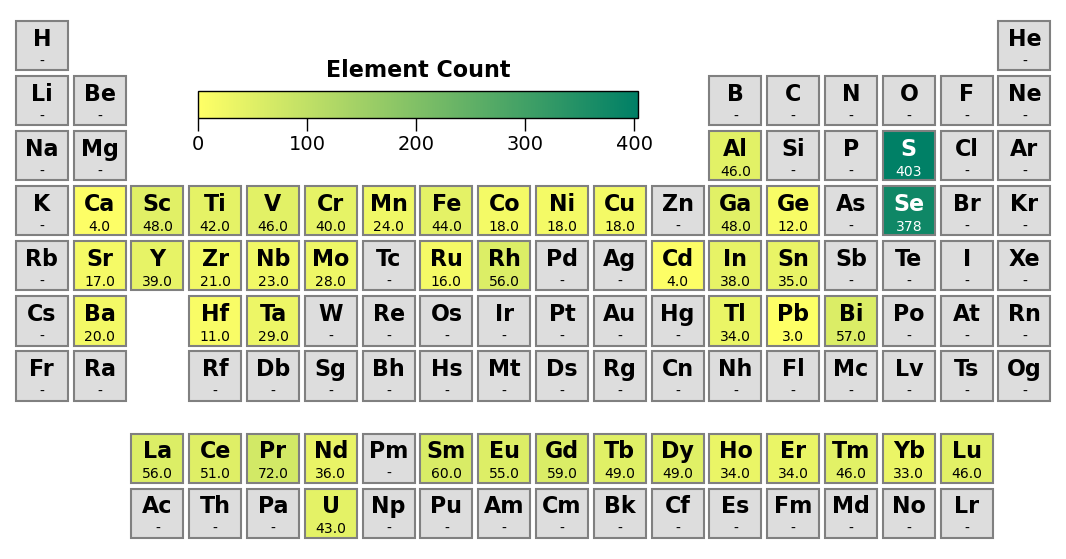

In [12]:
stable_candidates_tau, df_out = check_stable_compositions('tau')

graph_periodic_table(stable_candidates_tau, 'tau')